In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import datetime
warnings.filterwarnings('ignore')
plt.rc('font', family='Malgun Gothic') 


In [99]:
# datetime을 index로 옮겨주는 함수
def datetime_revise(df):
    # python datetime에서는 시간을 0~23시까지밖에 인식을 못하기 때문에 1을 빼준다.
    df.index = pd.to_datetime(df['datetime']) + pd.to_timedelta(df['hour'], unit='hours')
    df.drop(['year', 'month', 'day', 'weekday', 'hour', 'datetime'], axis=1, inplace=True)
    return df

In [100]:
# 시계열 분석을 위해 target값만을 뽑음
def make_df(df, colname):
    df = df.query(f'supplys == "{colname}"')
    return df['target']

In [101]:
# upsamplingm downsampling해줄 수 있도록 하는 함수
def set_freq(df, freq='m'):
    return pd.DataFrame(df.resample(freq).sum())

In [102]:
total = pd.read_csv('data/no_outlier_data.csv')
total = datetime_revise(total)
total.head()


,supplys,avg_temp,mini_temp,max_temp,target
2013-01-01 01:00:00,A,-3.2,-9.1,2.6,2497.129
2013-01-01 02:00:00,A,-3.2,-9.1,2.6,2363.265
2013-01-01 03:00:00,A,-3.2,-9.1,2.6,2258.505
2013-01-01 04:00:00,A,-3.2,-9.1,2.6,2243.969
2013-01-01 05:00:00,A,-3.2,-9.1,2.6,2344.105


In [103]:
# 공급사 이름
supply_name_list = [n for n in total['supplys'].unique().tolist()]
supply_name_list

['A', 'B', 'C', 'D', 'E', 'G', 'H']

# 시계열 데이터 탐색

In [104]:
# acf, pacf graph
import statsmodels.graphics.tsaplots as sgt

In [105]:
import statsmodels.tsa.stattools as sts

# 한 번에 분석하기 용이하도록 각 공급사별로 일별 공급 데이터만 담긴 series를 따로 저장
colname = total['supplys'].unique().tolist()

In [9]:
day_time_series = [set_freq(make_df(total, col), freq='d') for col in colname]
day_time_series[1]

,target
2013-01-01,50066.659
2013-01-02,62056.072
2013-01-03,67115.432
2013-01-04,65465.912
2013-01-05,59687.032
...,...
2018-12-28,62650.797
2018-12-29,58113.026
2018-12-30,55571.384
2018-12-31,57729.648


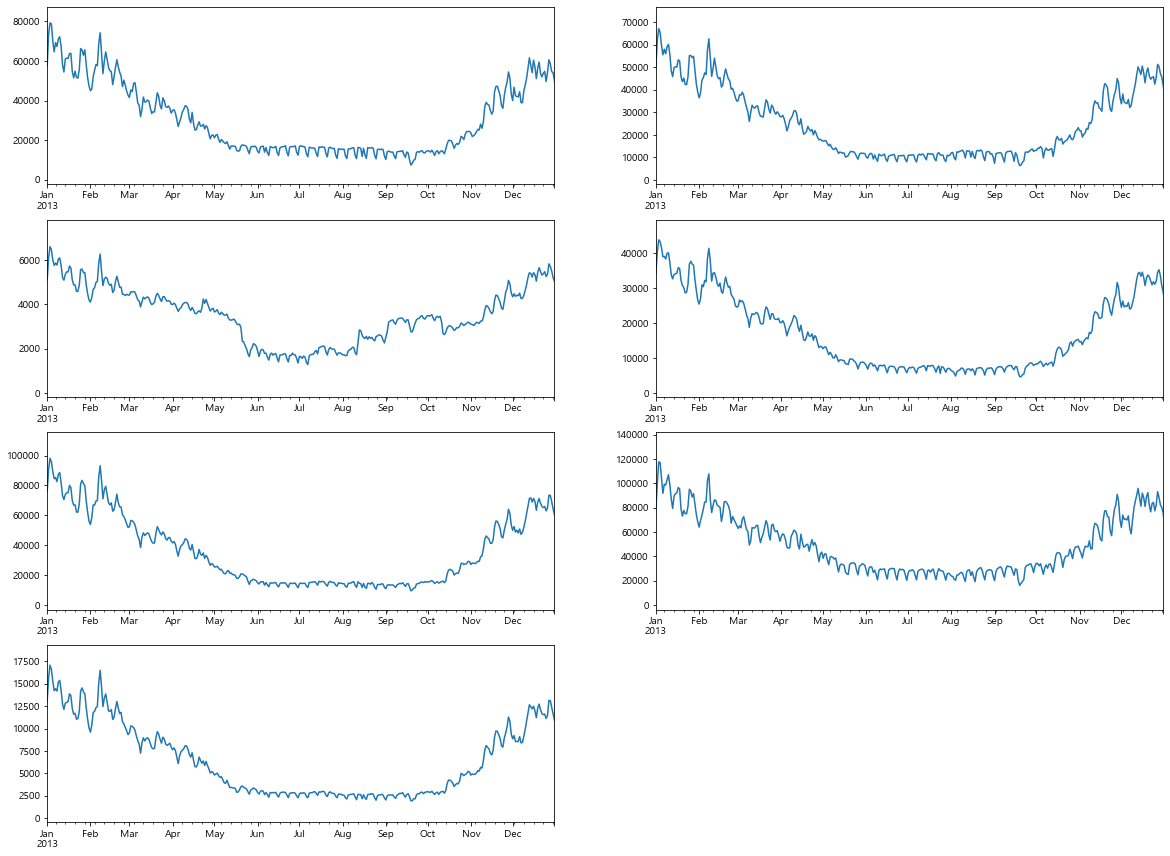

In [10]:
# 일별 시계열 데이터를 도식화 (1년 표시)
plt.subplots(figsize=(20, 15))

for idx, t_df in enumerate(day_time_series):
    ax = plt.subplot(4, 2, idx+1)
    t_df['target'].plot(xlim=[datetime.date(2013, 1, 1), datetime.date(2013, 12, 31)])

## lstm

In [11]:
import numpy as np
import pandas as pd
import io
import warnings 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
warnings.filterwarnings('ignore')                  # Turn the warnings off.
%matplotlib inline

In [12]:
hour_time_series = [set_freq(make_df(total, col), freq='h') for col in colname]
hour_time_series[1]

,target
2013-01-01 01:00:00,2169.093
2013-01-01 02:00:00,2051.733
2013-01-01 03:00:00,1923.253
2013-01-01 04:00:00,1927.253
2013-01-01 05:00:00,2047.333
...,...
2018-12-31 20:00:00,2668.688
2018-12-31 21:00:00,2606.681
2018-12-31 22:00:00,2540.169
2018-12-31 23:00:00,2407.945


In [13]:
df = hour_time_series[0]
df.head()

,target
2013-01-01 01:00:00,2497.129
2013-01-01 02:00:00,2363.265
2013-01-01 03:00:00,2258.505
2013-01-01 04:00:00,2243.969
2013-01-01 05:00:00,2344.105


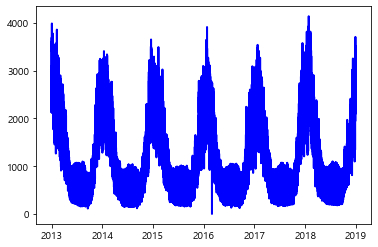

In [14]:
# 시계열 시각화.
plt.plot(df.target, c="b", linewidth=2, linestyle="-")
plt.show()

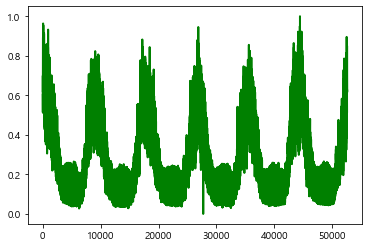

In [62]:
# Scaling.
# 아래 그래프에서 세로축의 scale에 주목!
my_scaler = MinMaxScaler()
ts_scaled_test = my_scaler.fit_transform(df)
plt.plot(ts_scaled_test,c = "g", linewidth=2, linestyle="-")
plt.show()

In [63]:
# Reshaping.
ts_scaled_2 = ts_scaled_test.reshape(1,-1,1)             # (batch_size, time series length, n_input)

In [64]:
idx_80 = int(len(ts_scaled_2.flatten()) * 0.8)
idx_80

42067

In [65]:
train, test = ts_scaled_2[:,:idx_80,:], ts_scaled_2[:,idx_80:,:]
test.shape

(1, 10517, 1)

In [66]:
n_epochs = 400                  
batch_size = 1                   # 데이터로 주어진 시계열은 단 한 개. 그러므로 batch_size = 1 이외의 선택은 없다.  
learn_rate = 0.0001       

In [67]:
n_input = 1                       # Scalar 값 입력.
n_hidden = 32                   # 층 별 neuron의 수.
n_output = 1                      # Scalar 값 출력.

In [68]:
# Import the necessary classes.
from tensorflow.keras.models import Sequential # Sequential API 예정.
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, TimeDistributed
# "sequence in and sequence out" model : at SimpleRNN() return_sequences=True.
my_model = Sequential()
my_model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(None, n_input))) # RNN.
my_model.add(TimeDistributed(Dense(units=n_output, activation="linear")))

In [69]:
# # RNN 또는 LSTM network.
# # return_sequences = True: "Sequence to Sequence" 모델을 의미한다.
# # input_shape = (None, n_input) :  "None"은 가변적인 시계열 길이를 나타낸다.
# my_model = Sequential()
# # my_model.add(SimpleRNN(units=n_hidden,return_sequences=True, input_shape=(None, n_input), activation="relu"))     # RNN.
# my_model.add(LSTM(units=n_hidden,return_sequences=True, input_shape=(None, n_input),activation="relu"))         # LSTM.
# my_model.add(TimeDistributed(Dense(units=n_output)))    # Wrapper.

In [70]:
# 모델의 summary (내부 구조) 출력.
my_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, None, 100)         10200     
                                                                 
 time_distributed_5 (TimeDis  (None, None, 1)          101       
 tributed)                                                       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [71]:
# Optimizer 객체 생성 후 컴파일한다.
my_optimizer=Adam(lr=learn_rate)
my_model.compile(loss = "mae", optimizer = my_optimizer, metrics=["mae"])


In [72]:
train[:,:-1,:].shape

(1, 42066, 1)

In [73]:
# No validation.
# 주의: y 는 X를 +1 shifting 한 것이다!!!
my_EarlyStop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)          # 조기 종료 허락!
my_summary = my_model.fit(train[:,:-1,:], train[:,1:,:], epochs=n_epochs, batch_size = batch_size, verbose = 1, callbacks=[my_EarlyStop])

Epoch 1/400
1/1 [==============================] - 9s 9s/step - loss: 0.1740 - mae: 0.1740
Epoch 2/400
1/1 [==============================] - 9s 9s/step - loss: 0.1432 - mae: 0.1432
Epoch 3/400
1/1 [==============================] - 9s 9s/step - loss: 0.1218 - mae: 0.1218
Epoch 4/400
1/1 [==============================] - 9s 9s/step - loss: 0.1128 - mae: 0.1128
Epoch 5/400
1/1 [==============================] - 10s 10s/step - loss: 0.1100 - mae: 0.1100
Epoch 6/400
1/1 [==============================] - 9s 9s/step - loss: 0.1050 - mae: 0.1050
Epoch 7/400
1/1 [==============================] - 9s 9s/step - loss: 0.0962 - mae: 0.0962
Epoch 8/400
1/1 [==============================] - 9s 9s/step - loss: 0.0858 - mae: 0.0858
Epoch 9/400
1/1 [==============================] - 9s 9s/step - loss: 0.0791 - mae: 0.0791
Epoch 10/400
1/1 [==============================] - 9s 9s/step - loss: 0.0779 - mae: 0.0779
Epoch 11/400
1/1 [==============================] - 9s 9s/step - loss: 0.0780 - mae: 0.

In [74]:
my_summary.history.keys()

dict_keys(['loss', 'mae'])

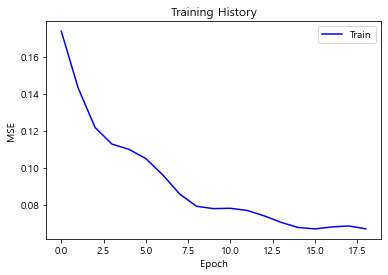

In [75]:
# 학습 history 출력. 
plt.plot(my_summary.history['mae'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [84]:
#예측
n_ts_seed = 5                               # Seed 길이.
n_predict_time_steps = 10000                  # 예측할 길이.

In [85]:
ts_scaled_test.shape

(52584, 1)

In [86]:
ts_scaled_test[0: n_ts_seed + n_predict_time_steps].shape

(10005, 1)

In [87]:
test[0, :n_ts_seed, 0].shape

(5,)

In [88]:
# 예측 루프.
ts_seed = test[0, :n_ts_seed, :]
print(ts_seed.shape)
for i in range(n_predict_time_steps):
    X = ts_seed.reshape(1,-1,1)        # Reshape.     
    y_pred = my_model.predict(X)
    y_last= y_pred[0,-1,0]             # 마지막 출력이 바로 y.
    ts_seed = np.concatenate((ts_seed, np.array([y_last]).reshape(-1,1)), axis=0)
    
    if i % 10 == 0:
        print(f"{i/n_predict_time_steps * 100}%")
print(ts_seed.shape)

(5, 1)
0.0%
0.1%
0.2%
0.3%
0.4%
0.5%
0.6%
0.7000000000000001%
0.8%
0.8999999999999999%
1.0%
1.0999999999999999%
1.2%
1.3%
1.4000000000000001%
1.5%
1.6%
1.7000000000000002%
1.7999999999999998%
1.9%
2.0%
2.1%
2.1999999999999997%
2.3%
2.4%
2.5%
2.6%
2.7%
2.8000000000000003%
2.9000000000000004%
3.0%
3.1%
3.2%
3.3000000000000003%
3.4000000000000004%
3.5000000000000004%
3.5999999999999996%
3.6999999999999997%
3.8%
3.9%
4.0%
4.1000000000000005%
4.2%
4.3%
4.3999999999999995%
4.5%
4.6%
4.7%
4.8%
4.9%
5.0%
5.1%
5.2%
5.3%
5.4%
5.5%
5.6000000000000005%
5.7%
5.800000000000001%
5.8999999999999995%
6.0%
6.1%
6.2%
6.3%
6.4%
6.5%
6.6000000000000005%
6.7%
6.800000000000001%
6.9%
7.000000000000001%
7.1%
7.199999999999999%
7.3%
7.3999999999999995%
7.5%
7.6%
7.7%
7.8%
7.9%
8.0%
8.1%
8.200000000000001%
8.3%
8.4%
8.5%
8.6%
8.7%
8.799999999999999%
8.9%
9.0%
9.1%
9.2%
9.3%
9.4%
9.5%
9.6%
9.700000000000001%
9.8%
9.9%
10.0%
10.100000000000001%
10.2%
10.299999999999999%
10.4%
10.5%
10.6%
10.7%
10.8%
10.9%
11.0%
1

In [92]:
test_original = np.array(df.iloc[idx_80:])
test_original.shape

(10517, 1)

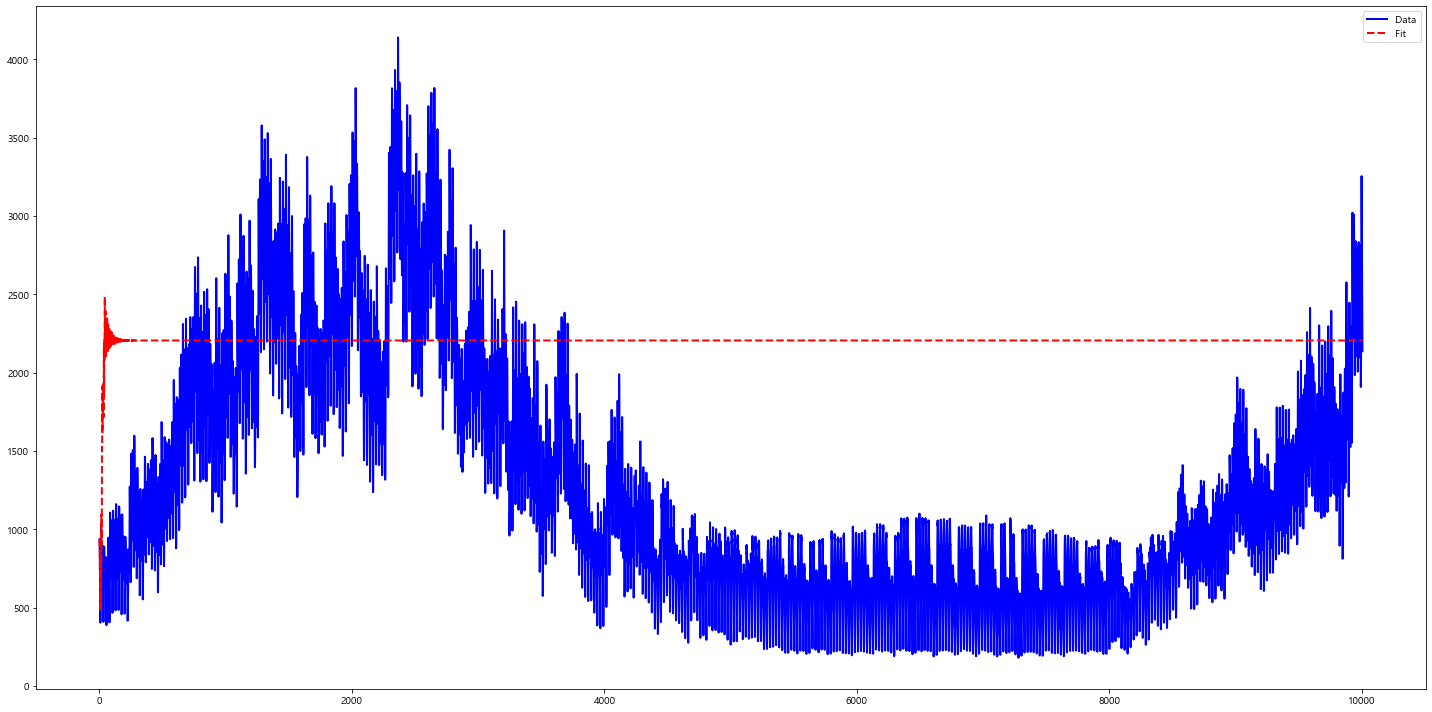

In [94]:
# 역변환을 하고 시계열을 출력한다.. 
ts = my_scaler.inverse_transform(ts_seed)
plt.figure(figsize=(20, 10))
plt.plot(test_original[:10005],c='b',linewidth=2, linestyle="-",label="Data")
plt.plot(ts,c='r',linewidth=2, linestyle="--",label="Fit")
plt.legend()
# plt.ylim([0,15])
plt.tight_layout()
plt.savefig("out.png")
plt.show()

In [91]:
from sklearn.metrics import mean_squared_error

In [63]:
mse = mean_squared_error(ts[5:], df.target[5:555])

In [106]:
 hour_time_list = [set_freq(make_df(total, col), freq='h') for col in colname]

## 1. 시간 단위 ACF, PACF

In [174]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt



# 학습 데이터를 생성한다.
# ex: data = [1,2,3,4,5,6,7,8,9,10]가 주어졌을 때 generateX(data, 5)를 실행하면
# 아래와 같은 학습데이터 변환한다.
#
# x                      y
# ---------              -
# 1,2,3,4,5              6
# 2,3,4,5,6              7
# 3,4,5,6,7              8
# ...
def generateX(a, n):
 x_train = []
 y_train = []
 for i in range(len(a)):
     x = a[i:(i + n)]
     if (i + n) < len(a):
         x_train.append(x)
         y_train.append(a[i + n])
     else:
         break
 return np.array(x_train), np.array(y_train)



# hour time list


A_df = hour_time_list[0]
x, y = generateX(A_df['target'], 10)
x, y = x[:9000], y[:9000]
x = x.reshape(-1,10,1)
y = y.reshape(-1,1)



# 학습용 데이터와 시험용 데이터
x_train = x[:7500, :, :]
y_train = y[:7500:, :]
x_test = x[7500:, :, :]
y_test = y[7500:, :]




x.shape


(9000, 10, 1)

In [176]:
y_test.shape

(1500, 1)

In [223]:
from tensorflow.keras.layers import Dense, Input, LSTM

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

import numpy as np

import matplotlib.pyplot as plt



def createTrainData(xData, step):

    m = np.arange(len(xData) - step)

    

    x, y = [], []

    for i in m:

        a = xData[i:(i+step)]

        x.append(a)

    xBatch = np.reshape(np.array(x), (len(m), step, 1))

    

    for i in m+1:

        a = xData[i:(i+step)]

        y.append(a[-1])

    yBatch = np.reshape(np.array(y), (len(m), 1))

    

    return xBatch, yBatch


# 시계열 데이터 (noisy sin)
scaler = MinMaxScaler()
data =  np.array(A_df['target'].iloc[:42000]).reshape(-1,1)
test = np.array(A_df['target'].iloc[42000:]).reshape(-1,1)
data_s = scaler.fit_transform(data)

nInput = 1

nOutput = 1

nStep = 24

nHidden = 50



# 학습 데이터를 생성한다.

x, y = createTrainData(data_s, nStep)

print(x.shape)



(41976, 24, 1)


In [224]:
# LSTM 모델을 생성한다.

xInput = Input(batch_shape=(None, nStep, 1))

xLstm = LSTM(nHidden)(xInput)

xOutput = Dense(nOutput)(xLstm)

model = Model(xInput, xOutput)

model.compile(loss='mae', optimizer=Adam(lr=0.01))



# 학습한다
my_EarlyStop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5) 
h = model.fit(x, y, epochs=500, batch_size=100, shuffle=False, callbacks=[my_EarlyStop])



# 향후 20 기간 데이터를 예측한다. 향후 1 기간을 예측하고, 예측값을 다시 입력하여 2 기간을 예측한다.

# 이런 방식으로 20 기간까지 예측한다.



Epoch 1/500
420/420 [==============================] - 4s 8ms/step - loss: 0.0422
Epoch 2/500
420/420 [==============================] - 3s 8ms/step - loss: 0.0194
Epoch 3/500
420/420 [==============================] - 3s 8ms/step - loss: 0.0194
Epoch 4/500
420/420 [==============================] - 3s 8ms/step - loss: 0.0156
Epoch 5/500
420/420 [==============================] - 3s 8ms/step - loss: 0.0160
Epoch 6/500
420/420 [==============================] - 3s 8ms/step - loss: 0.0157
Epoch 7/500
420/420 [==============================] - 3s 8ms/step - loss: 0.0157
Epoch 8/500
420/420 [==============================] - 4s 8ms/step - loss: 0.0147
Epoch 9/500
420/420 [==============================] - 4s 8ms/step - loss: 0.0143
Epoch 10/500
420/420 [==============================] - 3s 8ms/step - loss: 0.0139
Epoch 11/500
420/420 [==============================] - 3s 8ms/step - loss: 0.0137
Epoch 12/500
420/420 [==============================] - 3s 8ms/step - loss: 0.0136
Epoch 13/500


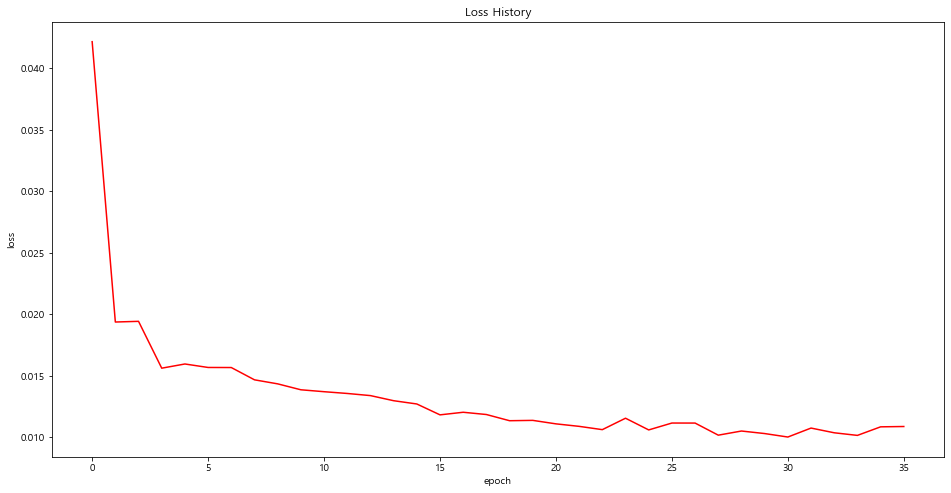

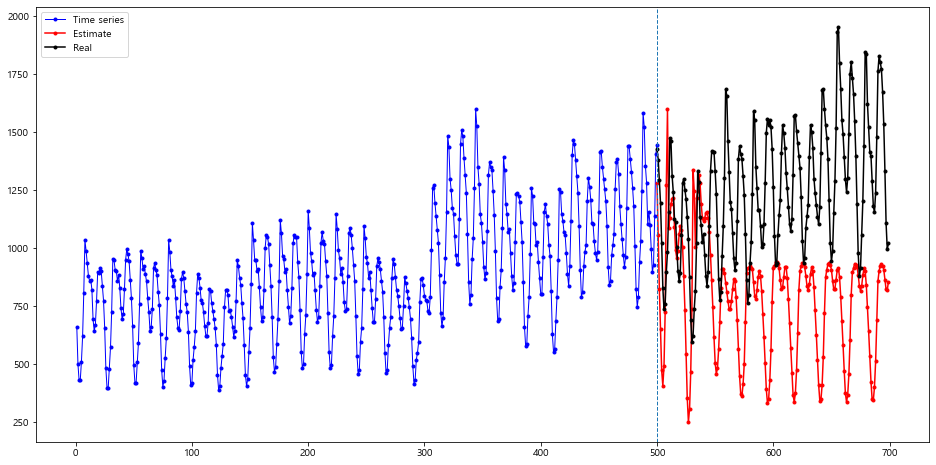

In [234]:
nFuture = 200
test_s = scaler.transform(test)


if len(data_s) > 500:

    lastData = np.copy(test_s[:500])  # 원 데이터의 마지막 100개만 그려본다

else:

    lastData = np.copy(test_s)

    

dx = np.copy(lastData)

estimate = [dx[-1]]

for i in range(nFuture):

    # 마지막 nStep 만큼 입력데이로 다음 값을 예측한다

    px = dx[-nStep:].reshape(1, nStep, 1)

    

    # 다음 값을 예측한다.

    yHat = model.predict(px)[0][0]

        

    # 예측값을 저장해 둔다
    estimate.append(yHat)

    

    # 이전 예측값을 포함하여 또 다음 값을 예측하기위해 예측한 값을 저장해 둔다

    dx = np.insert(dx, len(dx), yHat)



# Loss history를 그린다

plt.figure(figsize=(16, 8))

plt.plot(h.history['loss'], color='red')

plt.title("Loss History")

plt.xlabel("epoch")

plt.ylabel("loss")

plt.show()

estimate_s = scaler.inverse_transform(np.array(estimate[1:]).reshape(-1,1))

# 원 시계열과 예측된 시계열을 그린다

ax1 = np.arange(1, len(lastData) + 1)

ax2 = np.arange(len(lastData), len(lastData) + len(estimate)-1)

ax3 = np.arange(len(lastData), len(lastData) + len(estimate)-1)


plt.figure(figsize=(16, 8))

plt.plot(ax1, test[:500], 'b-o', color='blue', markersize=3, label='Time series', linewidth=1)

plt.plot(ax2, estimate_s, 'b-o', color='red', markersize=3, label='Estimate')

plt.plot(ax2, test[500:500+nFuture], 'b-o', color='black', markersize=3, label='Real')

ax2 = np.arange(len(lastData), len(lastData) + len(estimate)-1)
plt.axvline(x=ax1[-1],  linestyle='dashed', linewidth=1)

plt.legend()

plt.show()


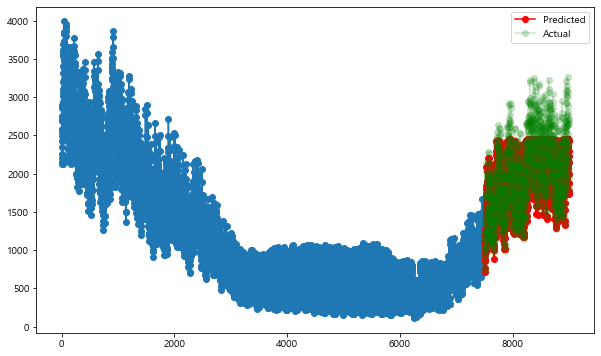

In [179]:
# # 예측 결과 시각화
# a_axis = np.arange(0, len(y_train))
# b_axis = np.arange(len(y_train), len(y_train) + len(y_hat))

# plt.figure(figsize=(10,6))
# plt.plot(a_axis, y_train.reshape(7500,), 'o-')
# plt.plot(b_axis, y_hat.reshape(1500,), 'o-', color='red', label='Predicted')
# plt.plot(b_axis, y_test.reshape(1500,), 'o-', color='green', alpha=0.2, label='Actual')
# plt.legend()
# plt.show()

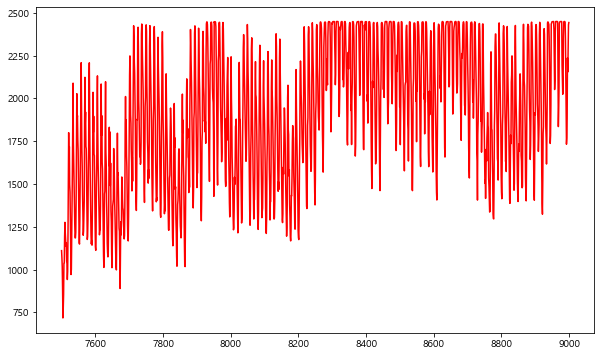

In [143]:
plt.figure(figsize=(10,6))
plt.plot(b_axis, y_hat.reshape(1500,), '-', color='red', label='Predicted')


In [130]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 


In [131]:
MAPE(y_test, y_hat)

5.19193282044426

array([2712.081])

## 양방향 lstm

In [240]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt



# 학습 데이터를 생성한다.
# ex: data = [1,2,3,4,5,6,7,8,9,10]가 주어졌을 때 generateX(data, 5)를 실행하면
# 아래와 같은 학습데이터 변환한다.
#
# x                      y
# ---------              -
# 1,2,3,4,5              6
# 2,3,4,5,6              7
# 3,4,5,6,7              8
# ...
def generateX(a, n):
 x_train = []
 y_train = []
 for i in range(len(a)):
     x = a[i:(i + n)]
     if (i + n) < len(a):
         x_train.append(x)
         y_train.append(a[i + n])
     else:
         break
 return np.array(x_train), np.array(y_train)



# hour time list


A_df = hour_time_list[0]
idx = int(len(A_df) *0.8)
train, test = A_df[:idx], A_df[idx:]


# scaler
scaler=MinMaxScaler()
train_s = scaler.fit_transform(train)
test_s = scaler.transform(test
                         
                         )
x_train, y_train = generateX(train_s, 10)
x_train = x_train.reshape(-1,10,1)
y_train = y_train.reshape(-1,1)


# x, y = x[:idx], y[:idx]
# x = x.reshape(-1,10,1)
# y = y.reshape(-1,1)


# 학습용 데이터와 시험용 데이터
# x_train = x[:idx, :, :]
# y_train = y[:idx:, :]


x_test, y_test =  generateX(test_s, 10)
x_test = x_test.reshape(-1,10,1)
y_test = y_test.reshape(-1,1)





print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


(42057, 10, 1) (42057, 1) (10507, 10, 1) (10507, 1)


In [241]:
# 2층-양방항 구조의 LSTM 모델을 생성한다.
K.clear_session()     # 모델 생성전에 tensorflow의 graph 영역을 clear한다.
xInput = Input(batch_shape=(None, x_train.shape[1], x_train.shape[2]))
xLstm_1 = LSTM(10, return_sequences = True)(xInput)
xLstm_2 = Bidirectional(LSTM(10))(xLstm_1)
xOutput = Dense(1)(xLstm_2)


model = Model(xInput, xOutput)
model.compile(loss='mae', optimizer='adam')
model.summary()

my_EarlyStop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5) 

# 학습
model.fit(x_train, y_train, epochs=500, batch_size=20,verbose=1, callbacks=[my_EarlyStop])





Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 10)            480       
                                                                 
 bidirectional (Bidirectiona  (None, 20)               1680      
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
2103/2103 [==============================] - 12s 4ms/step - loss: 0.0413
Epoch 2/500
2103/2103 [=================

In [ ]:


# 예측
y_hat = model.predict(x_test, batch_size=1)

In [405]:
nFuture = 1000
# test_s = scaler.transform(y_test)
# if len(data_s) > 100:
#     lastData = np.copy(test_s[-100:])  # 원 데이터의 마지막 100개만 그려본다
# else:
#     lastData = np.copy(test_s)

dx = np.copy(x_test[:1])

estimate = [dx[-1]]

for i in range(nFuture):

    # 마지막 nStep 만큼 입력데이로 다음 값을 예측한다
#     print(dx[-1])
    px = dx[-1].reshape(1, 10, 1) # nstep->10
    
    

    # 다음 값을 예측한다.
    yHat = model.predict(px)


    # 예측값을 저장해 둔다
    estimate.append(yHat)

    
    dx_tmp = dx[-1]
#     print(f'이전 dx : {dx[-1]}', end='\n\n')
    # 이전 예측값을 포함하여 또 다음 값을 예측하기위해 예측한 값을 저장해 둔다
    tmp = np.insert(dx_tmp[1:], 9, yHat).reshape(-1, 1)
#     print(f"tmp : {tmp}")
    dx = np.insert(dx, dx.shape[0], tmp, axis=0).reshape(-1, 10, 1)
#     print(f'이후 dx : {dx[-1]}', end='\n\n')



Exception ignored in: <function ScopedTFGraph.__del__ at 0x000001E63AEEEDC0>
Traceback (most recent call last):
  File "C:\Users\park123\anaconda3\envs\gas_env\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 58, in __del__
    self.deleter(self.graph)
AttributeError: deleter


In [397]:
y_test_real = scaler.inverse_transform(y_test[:nFuture])
estimate_real = scaler.inverse_transform(np.array(estimate[1:]).reshape(-1,1))

In [398]:
print(y_test_real.shape, estimate_real.shape)

(1000, 1) (1000, 1)


<AxesSubplot:>

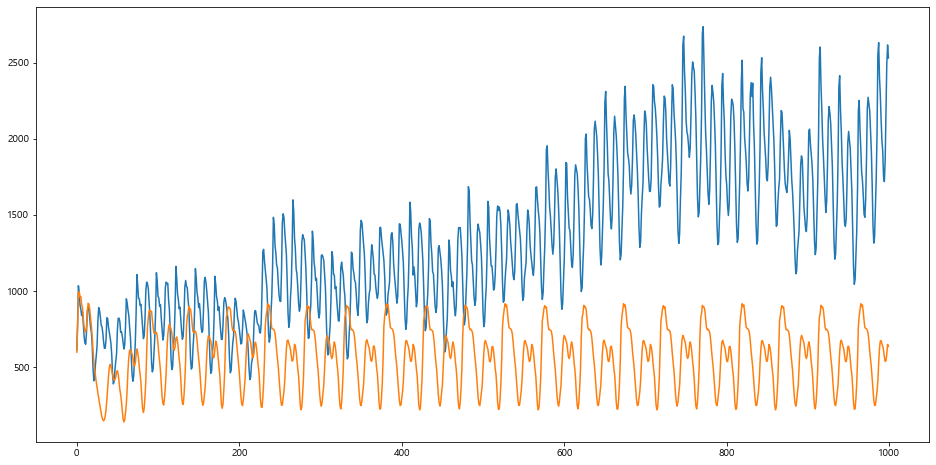

In [402]:
plt.figure(figsize=(16,8))
pd.Series(y_test_real.reshape(-1,)).plot()
pd.Series(estimate_real.reshape(-1,)).plot()

In [312]:
kk = np.array([[[1,2,3,4]]])
kk.shape

(1, 1, 4)

ValueError: cannot reshape array of size 1500 into shape (10517,)

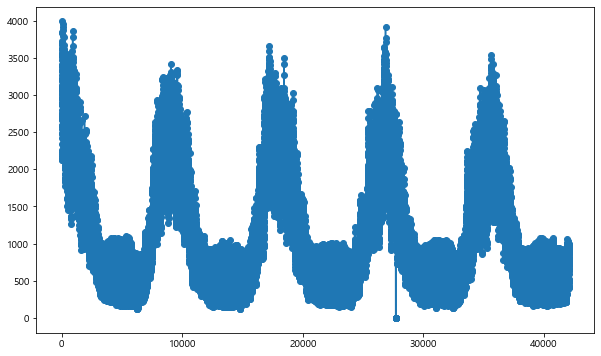

In [170]:
a_axis = np.arange(0, len(y_train))
b_axis = np.arange(len(y_train), len(y_train) + len(y_hat))

plt.figure(figsize=(10,6))
plt.plot(a_axis, y_train.reshape(42067,), 'o-')
plt.plot(b_axis, y_hat.reshape(10517,), 'o-', color='red', label='Predicted')
plt.plot(b_axis, y_test.reshape(10517,), 'o-', color='green', alpha=0.2, label='Actual')
plt.legend()
plt.show()



In [169]:
len(A_df) - 42067

10517